First, Thanks to Nwamaka's medium post(https://medium.com/nwamaka-imasogie/clinicalbert-using-deep-learning-transformer-model-to-predict-hospital-readmission-c82ff0e4bb03), which offers the data preprocessing stage as well as some guidance on classification. The following project will read the data from the pre-processed stage, and perform the machine learning techniques on Readmission prediction.

This part is a good supplement for real-time text prediction. We can get strucutured data immediately, but it has a lag(The hospital will not count the structured data until the end of the day!). This is the reason why NLP could help on real-time predicting.

We will mainly focus on:

1. Simple convertion of word vectors

2. Data Exploration and unbalanced data issue

3. Applying more complex model to improve the roc_auc score

We intentionaly kept the code not that consise (you might see repeated use of code). The reason is that we left an analytic procedure to you

The result might seems not quite good since both unbalanced data effect and there is few NLP task exploration on this dataset. Even the original author just got 0.76 ROC_AUC score. We want to explore NLP method rather than beating anyone!

# Step 1: Read the pre-processed data and EDA

1. in this section, we read the data from the what the authoer have preprocessed (3 days readmission except balancing stage).
2. we will do data exploaration before applying machine learning model.

Imagine that, you only have the text data, nothing else!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df=pd.read_pickle('./pickle/df_less_3.pkl')

In [3]:
df.groupby('Label').count()


,ID,TEXT
Label,,
0.0,355589,355589
1.0,30135,30135


We can see this is an unbalanced dataset with 1:12 of positive against negative samples.


In [4]:
df['text_len']=df.TEXT.apply(lambda x:len(x))
print('the maximum length is ...', df.text_len.max())
print('the minimum length is ...', df.text_len.min())

the maximum length is ... 3517
the minimum length is ... 43


This is to make sure during word embedding(above is just the string length, not how many words), we wont suffer a very long sentence.In addition, we want to know the range of the possible length of our texts.

In [5]:
df.isna().sum()

ID          0
TEXT        0
Label       0
text_len    0
dtype: int64

Good! we have no NaN data

Now, lets split our data to train/val/test.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,['TEXT','text_len']],df['Label'], test_size=0.3, random_state=0)

In [7]:
df_train=pd.DataFrame(X_train)
df_train

,TEXT,text_len
294746,explanation given acute change in imaging. len...,2112
33668,sinus tachycardia. probable left ventricular h...,2195
197820,"course: 66f with afib on coumadin, remote h/o ...",1849
90785,cholycystitis with common bile duct stones wit...,1883
34373,full code (was noted to be dnr/dni prior to ad...,1935
...,...,...
359783,ivl. piv x site wnl. patent. social: no family...,224
358083,ml d5w acetaminophen aspirin ec aspirin atorva...,1926
152315,man with left renal mass and h/o subdural hemm...,1798
117952,icu care nutrition: glycemic control: lines: 1...,1867


In [8]:
print('the ratio of pos/neg in training set ',sum(y_train==1)/sum(y_train==0))
print('the ratio of pos/neg in test set ',sum(y_test==1)/sum(y_test==0))

the ratio of pos/neg in training set  0.08377385754711301
the ratio of pos/neg in test set  0.08702350310932422


Before we do NLP processing, we also want to know weather the basic statistic information is useful to distinguish the readmission. For example, the length of the "TEXT" column


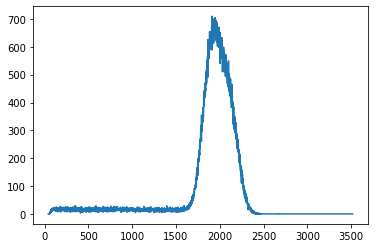

In [9]:
info=df_train.groupby('text_len',as_index=0).count()

plt.plot(info.text_len,info.TEXT)

The distribution of text_len against how many Labels seem very normal. We wonder if the pos/neg labels also follow such distribution. Hence, lets do a very simple logistic regression by using only the "text_len" as the features.

Lets check the ratio of pos/neg

In [10]:
print('the ratio of pos/neg is: ',sum(y_train==1)/sum(y_train==0))

the ratio of pos/neg is:  0.08377385754711301


We can see since the data is imbalanced 1:12.5, our grid search should from 1:5 to 1:15.

Also, we will use GridSearch to find the best weights.

According to the metrics of binary classification. We will use ROC/AUC curve as the evaluation.The benefit is that we could avoid bias on recall/precision trade-off since the final result is based upon the ROC's area.

To generate the K-fold, we use RepeatedStratifiedKFold because it could generate sub-group as the original dataset distribution.

Finally, we will use the best weights to fit the model.

**However, below is a demonstration example to show you how the unbalanced model might cheat you.**

In [11]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold # this gurantee each split is almost follow the distribution of the original dataset
from sklearn.linear_model import LogisticRegression

X=df_train['text_len'].values.reshape(-1,1)
y=y_train.values

model = LogisticRegression(solver='lbfgs')

grid_val=[dict({0:1,1:j}) for j in range(1,6) ]
param_grid = dict(class_weight=grid_val)
cv = RepeatedStratifiedKFold(n_splits=6)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

grid_result = grid.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.512811 using {'class_weight': {0: 1, 1: 2}}
0.487189 (0.004305) with: {'class_weight': {0: 1, 1: 1}}
0.512811 (0.004305) with: {'class_weight': {0: 1, 1: 2}}
0.487189 (0.004305) with: {'class_weight': {0: 1, 1: 3}}
0.512811 (0.004305) with: {'class_weight': {0: 1, 1: 4}}
0.487189 (0.004305) with: {'class_weight': {0: 1, 1: 5}}


In [12]:
cls=LogisticRegression().fit(X, y)

F:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [13]:
sum(cls.predict(X)) #see， we have make all prediction to negative label！

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y, cls.predict(X)).ravel()


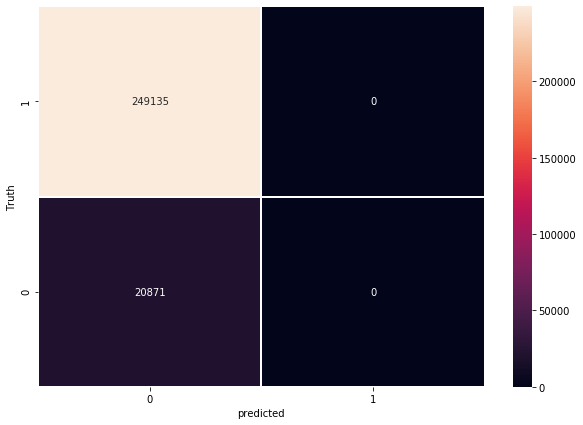

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as  sns

cm = np.array([[fn,tp],[tn,fp]])

plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,linewidths=1, fmt = 'd')
plt.xlabel('predicted')
plt.ylabel('Truth')
plt.ylim([0,2])
plt.show()

The above model reports TP+FP=0, which means that all instances were predicted as negative.

In addition, it indicates that it is impossible to predict the label only on sentence length!

Now, we can see that for unbalanced data, we must consider using AUC curve as the metric, instead of either precision/recall rate

# Step 2: First Attempt and Problem Finding

1. In this part, we are going to use pre-trained word vector from spacy library.
2. The kernel of NLP job is to think about "word_embedding". The major methods to convert one word or sentence to a vector are: 'one-hot encoding' 'statistical_based embedding',and 'word_embedding' : 







    one-hot encoding is sparse and orthogonal between each word, also huge cost on memory space
    
    word_embedding is an dense representation of words involving the pre-trained information. You could simply think word_embedding is a universal method like dimensionality reduction, signal capture or compression.
    
    word_embedding includes statis and dynamic types. For example, one word maps to one unique vector is called static embedding(Word2vec). Whereas one word maps to one vector based upon some given contextual texts called dynamic embedding(Bert).
    
    
    

In this project, we will focus on  static "word_embedding", which is 'Glove'. By the time limitation, We will only focus on static word embedding. Nwamaka already implemented the clinical bert pipeline, we do not want to just simply re-run her code and instead we want to explore the project on our own knowledge and interests.
    


# 2.1: We use the pre-trained model from Spacy library to get the word embedding:


Here we use "en_ner_bionlp13cg_md" model, which is a very complex model for Named Entity Recognition(NER) task. NER task requires a supervised learning which involves TAGs on each word in a sentence. For example, "en_ner_bionlp13cg_md" model's main job is to recognize the possible biological/clinical/medical names in the sentences. We will call the function to get the pre-trained word vector on that task.

*please see https://allenai.github.io/scispacy/ for detailed introduction and installation*

In [15]:
import scispacy
import spacy
import en_core_sci_sm   
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker


import en_ner_bionlp13cg_md
nlp = spacy.load("en_ner_bionlp13cg_md")


In [16]:
doc=nlp(df_train.TEXT[1])

# Attention, you need to close the displacy.serve by yourself to continue running codes below

In [17]:
displacy.serve(doc, style="ent")

F:\anaconda\lib\runpy.py:193: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  "__main__", mod_spec)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


We can see the entity has been already perfect marked by using this model.Hence, we can use the word vectors directly from this model to convert each sentence to a numerical vector.

We first make some samples

In [18]:
df_sample=df.sample(3000,random_state=0)
df_sample.groupby('Label').count()

,ID,TEXT,text_len
Label,,,
0.0,2742,2742,2742
1.0,258,258,258


In [19]:
import time

count=0
begin=time.time()
def get_ner_wv(text):
    global count
    global begin
    count+=1
    if count%1000==0:
        print('now processing.... ',count,' time cost...... ',time.time()-begin,' s')
    doc=nlp(text)
    return doc.vector

#df_sample=df_train.sample(3000)
#df_train['ner_wv']=df_train.TEXT.apply(get_ner_wv)

In [20]:
df_sample['word2vec']=df_sample.TEXT.apply(get_ner_wv)



now processing....  1000  time cost......  46.94900703430176  s
now processing....  2000  time cost......  91.73923444747925  s
now processing....  3000  time cost......  136.30502367019653  s


In [21]:
df_sample

,ID,TEXT,Label,text_len,word2vec
27280,107136.0,remove picc and send tip...wean neo to map >.....,1.0,1941,"[0.029284183, 0.014483439, 0.06752385, 0.00371..."
241706,162488.0,of readiness for learning action: mi teaching ...,0.0,2016,"[-0.0017557873, 0.046223473, 0.10897355, 0.027..."
199909,151376.0,is normal (lvef>55%). right ventricle: right v...,0.0,2256,"[0.009158471, 0.06597229, 0.0048928526, -0.035..."
175220,145096.0,"represents a fat pad, though a loculated anter...",0.0,2163,"[-0.006347567, 0.075405955, 0.046496622, -0.00..."
163835,141915.0,was briefly placed on cpap. no abg obtained. v...,0.0,2016,"[-0.0011737325, 0.027778277, 0.1136065, -0.004..."
...,...,...,...,...,...
290671,175091.0,supraventricular tachycardia left axis deviati...,0.0,2077,"[0.023522438, 0.047339242, 0.056796785, 0.0157..."
152991,139055.0,16 (11 - 24) insp/min spo2: 93% heart rhythm: ...,0.0,1763,"[0.055983152, 0.03939668, 0.09662792, 0.032728..."
384581,199679.0,"sinus tachycardia, rate left atrial abnormalit...",0.0,2211,"[-0.01792933, 0.046701074, 0.086492136, 0.0291..."
240217,162171.0,seen. pericardium: there is a small to moderat...,0.0,877,"[0.0026870752, 0.12834427, 0.022967158, 0.0031..."


In [22]:
def logit_NLP(X,Y,title):
    
    print('this is for....',title,'\n\n\n*********************')
    model = LogisticRegression(solver='lbfgs')

    grid_val=[dict({0:1,1:j}) for j in range(1,5) ]
    param_grid = dict(class_weight=grid_val)
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=6)
    # define grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
    # execute the grid search
    grid_result = grid.fit(X, Y)
    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # report all configurations
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    print('\n\n\n*********************')

In [23]:
from sklearn.metrics import roc_auc_score

X_wv= df_sample.word2vec.apply(pd.Series).values
X_num=df_sample['text_len'].values.reshape(-1,1)
Y=df_sample.Label


logit_NLP(X_wv,Y,'word vector')
logit_NLP(X_num,Y,'number')

this is for.... word vector 


*********************
Best: 0.566964 using {'class_weight': {0: 1, 1: 4}}
0.560954 (0.039526) with: {'class_weight': {0: 1, 1: 1}}
0.563428 (0.039004) with: {'class_weight': {0: 1, 1: 2}}
0.565391 (0.039223) with: {'class_weight': {0: 1, 1: 3}}
0.566964 (0.039450) with: {'class_weight': {0: 1, 1: 4}}



*********************
this is for.... number 


*********************
Best: 0.539913 using {'class_weight': {0: 1, 1: 3}}
0.525201 (0.059190) with: {'class_weight': {0: 1, 1: 1}}
0.537130 (0.052535) with: {'class_weight': {0: 1, 1: 2}}
0.539913 (0.050453) with: {'class_weight': {0: 1, 1: 3}}
0.537130 (0.052535) with: {'class_weight': {0: 1, 1: 4}}



*********************


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification



clf = RandomForestClassifier(random_state=0)
clf.fit(X_wv[1:2500], Y[1:2500])

roc_auc_score(Y[2500:],clf.predict(X_wv[2500:]))



F:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.4956043956043956

In [25]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_wv[1:2500], Y[1:2500])
roc_auc_score(Y[2500:],clf.predict(X_wv[2500:]))

0.484981684981685

In [26]:
pred=clf.predict(X_wv[2200:])
print(sum(pred==1),sum(pred==0))

74 726


# Now, we can get two conclusions:
    
1. We are still facing unbalanced dataset and majority of machine learning model are very sensitive to unbalanced data!

2. The count-based information is narrow, we need to expand word to vectors to represent more meanings.

*So, do we have some solutions to solve such unbalanced data and applied more complex NLP model？*

# Step 3: Solving the problem

Unfortunately, there is no end-to-end solution to solve such unbalanced data problem. All methods are facing challenges when the environment changes. That is the reason why the company still requires data team write a lot of SQL to deeply dig the data rather than auto machine learning. 

Right now, the most popular solutions are still: upsampling, downsampling, modified class weight and SMOTE. SMOTE works in feature space. It means that the output of SMOTE is not a synthetic data which is a real representative of a text inside its feature space.On one side SMOTE works with KNN and on the other hand, feature spaces for NLP problem are dramatically huge. KNN will easily fail in those huge dimensions.

Here we already tried adjustment on weights. It does not work well. For SMOTE method, it is to create artificial data point by using interpolation method. You may still think it is a more smoothy method to change the distribution of data, but the trade-off is that it is time-costly.

Now, I want to use the fastest method by rebalancing the data from the original dataset.

In [3]:


split=int(df.shape[0]*0.75)

seed=0

kaka=df.iloc[0:300000,:].sample(100000)


g = df.groupby('Label')
final=g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
final.index=range(final.shape[0])

final=final.sample(30000)


In [4]:
train_df=final[0:20000]
test_df=final[20000:] 

#we must make sure there is no any overlap dataset between train and test dataset

In [5]:
final.groupby('Label').count()

,ID,TEXT
Label,,
0.0,15061,15061
1.0,14939,14939


In [6]:
train_df.groupby('Label').count()

,ID,TEXT
Label,,
0.0,10095,10095
1.0,9905,9905


In [7]:
test_df.groupby('Label').count()

,ID,TEXT
Label,,
0.0,4966,4966
1.0,5034,5034


Above, train dataset holds a sound distribution with 1:1. This could help the model to make classification. But the test dataset should follow the original distribution

In [8]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

# Step 4: NLP and experienment

In this stage, we will explore experienment modern techniques in NLP. Performing word embedding+ contrcution of model in Pytorch.
There are diverse word embedding method possible to be selected, and each of them might bring different performance. The code below was modified from
https://www.kaggle.com/swarnabha/pytorch-text-classification-torchtext-lstm


There are several things to be noticed. The RNN model does the same thing like general NN model except it adds one more step to process the sequantial data. For example, it adds a for loop to pass the sequential data until the last output. This property forces the embedding dimensionality to be the same, so the sentences in each batch must keep the same length. We will talk more details as we go there. Before we go, these links are very helpful to read for a better understanding on NLP processing. We will use torchtext to help us maintain the structure of the data. 

Word Embedding with real example: https://towardsdatascience.com/from-pre-trained-word-embeddings-to-pre-trained-language-models-focus-on-bert-343815627598

RNN numpy implementation: https://victorzhou.com/blog/intro-to-rnns/



What we did different?

1. modified the word embedding methods and parameters

2. changed the structure of models

3. added ROC_AUC metrics and test dataset within evaluation stage

4. picked better hyper-parameters

First, lets show a demonstration of how pytorch get the corresponding word vectors.


In [9]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

import torch
from torchtext import data
import torch.nn as nn

In [10]:
emb=nn.Embedding(10,2)
emb.weight

Parameter containing:
tensor([[ 0.3128, -1.0663],
        [ 0.9047, -1.2541],
        [-0.5348, -0.4384],
        [ 0.5261, -1.1570],
        [-0.8455,  0.6700],
        [-0.4973,  0.3867],
        [ 0.0025,  0.9776],
        [-0.2608,  0.4132],
        [ 0.8033,  0.1650],
        [-0.0236,  0.1517]], requires_grad=True)

In [11]:

emb(torch.tensor([1,2,4,6]))

tensor([[ 0.9047, -1.2541],
        [-0.5348, -0.4384],
        [-0.8455,  0.6700],
        [ 0.0025,  0.9776]], grad_fn=<EmbeddingBackward>)

nn.embedding does nothing but provide a look-up table for us to check the corresponding word's vector by given the index
We will pass the pre-trained embedding to that field when initialize the model

In [13]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)



train_df, valid_df = train_test_split(train)




import spacy
spacy_en = spacy.load("en_ner_bionlp13cg_md")

def tokenizer(text): # create a tokenizer function
    # return a list of <class 'spacy.tokens.token.Token'>
    return [tok.text for tok in spacy_en.tokenizer(text)]


TEXT = data.Field(tokenize = tokenizer, include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)



class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.Label if not is_test else None
            text = row.TEXT
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            print('do train')
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            print('do valid')
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            print('do test')
            test_data = cls(test_df.copy(), data_field, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)
    
fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds ,test_ds= DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df,test_df=test)




(20000, 4)
do train
do valid
do test


In [14]:
MAX_VOCAB_SIZE = 10000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.50d',
                 unk_init = torch.Tensor.zero_)

LABEL.build_vocab(train_ds)



Above is an essential step which load the pretrained word embedding. The Glove model, is a static model which means we can immediately load a word vector just by calling .vector(word). Static embedding means one-to-one which implies there will be no association with the contextual words. For example: "I ate apple", "Apple stock will split with ratio 2:1 in 2021, reported by Yahoo Finance" will return the same vector for word apple. For more details, please check the links at the top.

Below, we will set the hyper-parameter for classification model. The reason we use RNN(LSTM) model is because we think there are some relationship between the words in each sentence. For example, a bone disease usually requires a radiology as the following precedure.

In [15]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'

train_iterator, valid_iterator,test_iterator = data.BucketIterator.splits(
    (train_ds, val_ds,test_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)


num_epochs = 10
learning_rate = 0.01

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        

        embedded = self.embedding(text)
        

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.fc1(hidden)
        output = self.fc2(output)
                
        #hidden = [batch size, hid dim * num directions]
            
        return output
    
model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)


model.to(device) 

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)










torch.Size([10002, 50])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [-0.4793, -0.0630, -0.4590,  ...,  0.9031,  0.2111,  0.1730],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2764, -0.1602,  0.0258,  ...,  0.0723, -0.0696, -0.1483]])
	Train Loss: 0.694 | Train Acc: 50.42%
	 Val. Acc: 48.64%
	 Val. ROC_AUC: 52.54%
	Train Loss: 0.676 | Train Acc: 58.22%
	 Val. Acc: 54.17%
	 Val. ROC_AUC: 56.85%
	Train Loss: 0.593 | Train Acc: 68.72%
	 Val. Acc: 56.39%
	 Val. ROC_AUC: 58.92%
	Train Loss: 0.469 | Train Acc: 77.72%
	 Val. Acc: 56.39%
	 Val. ROC_AUC: 59.21%
	Train Loss: 0.349 | Train Acc: 84.88%
	 Val. Acc: 57.22%
	 Val. ROC_AUC: 59.36%
	Train Loss: 0.250 | Train Acc: 89.40%
	 Val. Acc: 55.93%
	 Val. ROC_AUC: 58.59%
	Train Loss: 0.184 | Train Acc: 92.38%
	 Val. Acc: 55.95

In [17]:
from sklearn.metrics import roc_auc_score

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    rounded_preds = (torch.sigmoid(preds)>0.32).float()
    #print(rounded_preds)
    #print(roc_auc_score(y.cpu().data.numpy(),rounded_preds.cpu().data.numpy()))

    
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    
    return acc,rounded_preds,torch.sigmoid(preds)


def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    pred_collect=torch.empty(0).cuda()
    y_collect=torch.empty(0).cuda()
    
    #count=0
    for batch in iterator:
        
        
        text, text_lengths = batch.text
        
        
        
        
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc ,_,pred_y= binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss = loss.item()+epoch_loss
        epoch_acc = acc.item()+epoch_acc
        
        pred_collect=torch.cat([pred_collect,pred_y])
        y_collect=torch.cat([y_collect,batch.label])
        
    
    #print(pred_collect.shape,y_collect.shape)
    
    auc=roc_auc_score(y_collect.cpu().data.numpy(),pred_collect.cpu().data.numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator),  auc


def evaluate(model, iterator):
    
    epoch_acc = 0
    
    model.eval()
    
    pred_collect=torch.empty(0).cuda()
    y_collect=torch.empty(0).cuda()
    y_prob=torch.empty(0).cuda()

    
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            
            
            acc,pred_y,prob= binary_accuracy(predictions, batch.label)
            
            epoch_acc = acc.item()+epoch_acc
            pred_collect=torch.cat([pred_collect,pred_y])
            y_collect=torch.cat([y_collect,batch.label])
            y_prob=torch.cat([y_prob,prob])

    try:       
        auc=roc_auc_score(y_collect.cpu().data.numpy(),y_prob.cpu().data.numpy())  
    except:
        auc='UNAVAILABLE'
    return epoch_acc / len(iterator),auc,y_collect,y_prob


t = time.time()
loss=[]
acc=[]
val_acc=[]
val_auc=[]

y_lab=None
y_pro=None


In [ ]:
for epoch in range(num_epochs):
    
    train_loss, train_acc,train_auc = train(model, train_iterator)
    valid_acc ,valid_auc,true_y,prob_y= evaluate(model, valid_iterator)

    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Val. ROC_AUC: {valid_auc*100:.2f}%')

    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    val_auc.append(valid_auc)

    
    
print(f'time:{time.time()-t:.3f}')



_,_,my_lab,my_prob=evaluate(model, valid_iterator)

#torch.save(model, 'LSTM_MODEL') save the model

pd.DataFrame(val_auc).to_csv('100batch_glove_200_lr_0.005.csv')




import matplotlib.pyplot as plt

my_prob=my_prob.cpu().data.numpy()
my_lab=my_lab.cpu().data.numpy()
np.sort(my_prob)

combine=[ [i,j] for i,j in zip(my_prob,my_lab)]

combine=sorted(combine)

combine=np.array(combine).reshape(len(combine),2)

combine=pd.DataFrame(combine,columns=['prob','label'])


max_thresh=0
max_th_ind=None
for th in combine.iloc[:,0]: #threshold
    combine['label_with_thresh']=combine['prob'].apply(lambda x: x>th)
    combine['label_with_thresh']=combine['label_with_thresh'].astype(int)
    combine['final']=(combine['label_with_thresh']==combine['label'])
    
    if combine['final'].sum()/combine.shape[0] >max_thresh:
        max_thresh=combine['final'].sum()/combine.shape[0]
        max_th_ind=th

In [16]:
print('suggested threshold:   ',max_th_ind)

suggested threshold:    0.3204619884490967


Now, we can see a tremendous improvement! At least the ROC_AUC curve is no longer 0.5(the minimum).
The reason is that, during the training stage, we must let the model learn something from the minor class. If the distribution of data is extremely unbalanced, the classifier is tend to think allocate all samples to the major class. By the GPU and time limitation, we will stop here.

In [18]:
a,b,c,d=evaluate(model, test_iterator)

In [19]:
a

0.5521496815286624

In [20]:
b

0.5749780808948891

In [21]:
torch.cuda.empty_cache() #clear our tinny 

Lets try what if the training dataset is not balanced

In [13]:
def run_LSTM(my_train,my_test,emb_model=None):

    train = my_train
    test =my_test

    print(train.shape)



    train_df, valid_df = train_test_split(train)





    import spacy
    spacy_en = spacy.load("en_ner_bionlp13cg_md")

    def tokenizer(text): # create a tokenizer function
        # return a list of <class 'spacy.tokens.token.Token'>
        return [tok.text for tok in spacy_en.tokenizer(text)]


    TEXT = data.Field(tokenize = tokenizer, include_lengths = True)
    LABEL = data.LabelField(dtype = torch.float)



    class DataFrameDataset(data.Dataset):

        def __init__(self, df, fields, is_test=False, **kwargs):
            examples = []
            for i, row in df.iterrows():
                label = row.Label if not is_test else None
                text = row.TEXT
                examples.append(data.Example.fromlist([text, label], fields))

            super().__init__(examples, fields, **kwargs)

        @staticmethod
        def sort_key(ex):
            return len(ex.text)

        @classmethod
        def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
            train_data, val_data, test_data = (None, None, None)
            data_field = fields

            if train_df is not None:
                print('do train')
                train_data = cls(train_df.copy(), data_field, **kwargs)
            if val_df is not None:
                print('do valid')
                val_data = cls(val_df.copy(), data_field, **kwargs)
            if test_df is not None:
                print('do test')
                test_data = cls(test_df.copy(), data_field, **kwargs)

            return tuple(d for d in (train_data, val_data, test_data) if d is not None)

    fields = [('text',TEXT), ('label',LABEL)]

    train_ds, val_ds ,test_ds= DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df,test_df=test)


    MAX_VOCAB_SIZE = 10000

    TEXT.build_vocab(train_ds, 
                     max_size = MAX_VOCAB_SIZE, 
                     vectors = 'glove.6B.50d',
                     unk_init = torch.Tensor.zero_)

    LABEL.build_vocab(train_ds)


    BATCH_SIZE = 64

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device='cpu'

    train_iterator, valid_iterator,test_iterator = data.BucketIterator.splits(
        (train_ds, val_ds,test_ds), 
        batch_size = BATCH_SIZE,
        sort_within_batch = True,
        device = device)


    num_epochs = 10
    learning_rate = 0.01

    INPUT_DIM = len(TEXT.vocab)
    EMBEDDING_DIM = 50
    HIDDEN_DIM = 50
    OUTPUT_DIM = 1
    N_LAYERS = 2
    BIDIRECTIONAL = True
    DROPOUT = 0.1
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

    class LSTM_net(nn.Module):
        def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                     bidirectional, dropout, pad_idx):

            super().__init__()

            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

            self.rnn = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers, 
                               bidirectional=bidirectional, 
                               dropout=dropout)

            self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)

            self.fc2 = nn.Linear(hidden_dim, 1)

            #self.dropout = nn.Dropout(dropout)

        def forward(self, text, text_lengths):

            # text = [sent len, batch size]


            embedded = self.embedding(text)

            packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

            packed_output, (hidden, cell) = self.rnn(packed_embedded)


            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
            output = self.fc1(hidden)
            output = self.fc2(output)

            #hidden = [batch size, hid dim * num directions]

            return output

    model = LSTM_net(INPUT_DIM, 
                EMBEDDING_DIM, 
                HIDDEN_DIM, 
                OUTPUT_DIM, 
                N_LAYERS, 
                BIDIRECTIONAL, 
                DROPOUT, 
                PAD_IDX)


    pretrained_embeddings = TEXT.vocab.vectors

    print(pretrained_embeddings.shape)
    model.embedding.weight.data.copy_(pretrained_embeddings)

    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    print(model.embedding.weight.data)


    model.to(device) #CNN to GPU


    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    from sklearn.metrics import roc_auc_score

    def binary_accuracy(preds, y):
        """
        Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
        """

        #round predictions to the closest integer
        #print('pred的shape.......',torch.sigmoid(preds).cpu().data.numpy())
        #rounded_preds = torch.round(torch.sigmoid(preds))
        rounded_preds = (torch.sigmoid(preds)>0.32).float()
        #print(rounded_preds)
        #print(roc_auc_score(y.cpu().data.numpy(),rounded_preds.cpu().data.numpy()))


        correct = (rounded_preds == y).float() #convert into float for division 
        acc = correct.sum() / len(correct)

        return acc,rounded_preds,torch.sigmoid(preds)


    def train(model, iterator):

        epoch_loss = 0
        epoch_acc = 0

        model.train()

        pred_collect=torch.empty(0).cuda()
        y_collect=torch.empty(0).cuda()

        #count=0
        for batch in iterator:

            
            text, text_lengths = batch.text





            optimizer.zero_grad()
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc ,_,pred_y= binary_accuracy(predictions, batch.label)

            loss.backward()
            optimizer.step()

            epoch_loss = loss.item()+epoch_loss
            epoch_acc = acc.item()+epoch_acc

            pred_collect=torch.cat([pred_collect,pred_y])
            y_collect=torch.cat([y_collect,batch.label])


        #print(pred_collect.shape,y_collect.shape)

        auc=roc_auc_score(y_collect.cpu().data.numpy(),pred_collect.cpu().data.numpy())

        return epoch_loss / len(iterator), epoch_acc / len(iterator),  auc


    def evaluate(model, iterator):

        epoch_acc = 0

        model.eval()

        pred_collect=torch.empty(0).cuda()
        y_collect=torch.empty(0).cuda()
        y_prob=torch.empty(0).cuda()



        with torch.no_grad():
            for batch in iterator:
                text, text_lengths = batch.text
                predictions = model(text, text_lengths).squeeze(1)

                #print('预测值',predictions.cpu().data.numpy())

                acc,pred_y,prob= binary_accuracy(predictions, batch.label)

                epoch_acc = acc.item()+epoch_acc
                pred_collect=torch.cat([pred_collect,pred_y])
                y_collect=torch.cat([y_collect,batch.label])
                y_prob=torch.cat([y_prob,prob])

        try:       
            auc=roc_auc_score(y_collect.cpu().data.numpy(),y_prob.cpu().data.numpy())  
        except:
            auc='UNAVAILABLE'
        return epoch_acc / len(iterator),auc,y_collect,y_prob


    t = time.time()
    loss=[]
    acc=[]
    val_acc=[]
    val_auc=[]

    y_lab=None
    y_pro=None

    for epoch in range(num_epochs):

        train_loss, train_acc,train_auc = train(model, train_iterator)
        valid_acc ,valid_auc,true_y,prob_y= evaluate(model, valid_iterator)


        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Acc: {valid_acc*100:.2f}%')
        print(f'\t Val. ROC_AUC: {valid_auc*100:.2f}%')


        loss.append(train_loss)
        acc.append(train_acc)
        val_acc.append(valid_acc)
        val_auc.append(valid_auc)

You could modify the build_vocab model as you want, we have tested them, actually, the heavier the pre-trained word vecotors is, the better prediction result is! For example, we tested "fasttext.en.300d", it is 6GB large and its performance overwhelmed "glove_200d". You can try it by yourself!

In [14]:
unbalance_auc=run_LSTM(df.sample(25000),test) #same test data, same size of the training data, but 1:12 distribution

(25000, 3)
do train
do valid
do test
torch.Size([10002, 50])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [-0.1632,  0.7213,  0.2655,  ...,  0.9811, -0.3158, -0.4866],
        [ 0.6568,  0.3503,  0.2384,  ...,  0.7875, -0.0827, -0.3559],
        [-0.4440, -0.1459,  0.2885,  ..., -0.3518,  0.1557,  1.0669]])
	Train Loss: 0.287 | Train Acc: 91.51%
	 Val. Acc: 91.87%
	 Val. ROC_AUC: 51.99%
	Train Loss: 0.269 | Train Acc: 91.90%
	 Val. Acc: 91.74%
	 Val. ROC_AUC: 52.83%
	Train Loss: 0.224 | Train Acc: 91.78%
	 Val. Acc: 88.41%
	 Val. ROC_AUC: 52.06%
	Train Loss: 0.169 | Train Acc: 92.98%
	 Val. Acc: 86.21%
	 Val. ROC_AUC: 53.15%
	Train Loss: 0.119 | Train Acc: 95.12%
	 Val. Acc: 86.27%
	 Val. ROC_AUC: 53.90%
	Train Loss: 0.074 | Train Acc: 97.07%
	 Val. Acc: 84.58%
	 Val. ROC_AUC: 52.71%
	Train Loss: 0.046 

This AUC score is lower than balanced dataset

Now, we want to try the if the balanced data can perform good even without NLP techniques. We will keep all hyper-parameter as the default set. 

In [ ]:
train_df['len']=train_df['TEXT'].apply(lambda x:len(x))
test_df['len']=test_df['TEXT'].apply(lambda x:len(x))


cls=LogisticRegression().fit(train_df['len'].values.reshape(-1,1),train_df['Label'])
test_n_roc=roc_auc_score(test_df['Label'],cls.predict(test_df['len'].values.reshape(-1,1)))
train_n_roc=roc_auc_score(train_df['Label'],cls.predict(train_df['len'].values.reshape(-1,1)))

In [ ]:
print('for simple counting on text len its test and train roc_auc are: ',test_n_roc,train_n_roc)

In [ ]:

clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_df['len'].values.reshape(-1,1),train_df['Label'])
test_tree_roc=roc_auc_score(test_df['Label'],cls.predict(test_df['len'].values.reshape(-1,1)))
train_tree_roc=roc_auc_score(train_df['Label'],cls.predict(train_df['len'].values.reshape(-1,1)))

In [ ]:
print('for tree model on simple counting on text len its test and train roc_auc are: ',test_tree_roc,train_tree_roc)

Unfortunately, the pure counting on length means nothing even we solve the unbalanced data!

Next, we convert to simple word_vector

In [ ]:
train_df['ner_wv']=train_df.TEXT.apply(get_ner_wv)


In [ ]:
test_df['ner_wv']=test_df.TEXT.apply(get_ner_wv)

Last, we want to try another pre-trained word2vec which is the spacy's model

In [ ]:
balan_wv_train=train_df.ner_wv.apply(pd.Series).values
balan_wv_test=test_df.ner_wv.apply(pd.Series).values
cls=LogisticRegression().fit(balan_wv_train,train_df['Label'])
test_n_roc=roc_auc_score(test_df['Label'],cls.predict(balan_wv_test))
train_n_roc=roc_auc_score(train_df['Label'],cls.predict(balan_wv_train))

In [ ]:
print('for tree model on average word vector，its test and train roc_auc are: ',test_n_roc,train_n_roc)

In conclusion, we first performed trivial experiments on unbalanced dataset with different machine learning models. All models performed bad since the unbalanced effect. After then, we rebalanced our training data, as well as involved NLP techniques to process the sequential text data. The step 4 implemented word embedding and LSTM model. We can see if we let the data be balanced, and use a much complex model, the result would be definitely goes better. For example, only simple text length cannot do anything. Then, we applied the average word vector on each sentence. The result demonstrated an improvement. Last, we applied sequential method(LSTM) with word embedding, there was another improvement on the result! The possible explanation are: the word embedding captures some similarity of word, which assigned same features to the same word; the sequential model capture some relationship between some clinical treatments.